In [22]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)


2.12.0


In [23]:
def pairwise_distance(point_cloud):
    """Compute pairwise distance of a point cloud."""
    diff = tf.expand_dims(point_cloud, 1) - tf.expand_dims(point_cloud, 2)
    square_diff = tf.math.square(diff)
    square_distance = tf.reduce_sum(square_diff, axis=-1)
    distance_matrix = square_distance
    return distance_matrix


In [24]:
def get_neighbors(point_cloud, k=20):
    """Get the k nearest neighbors for each point in the point cloud."""
    pairwise_dist = pairwise_distance(point_cloud)
    _, indices = tf.nn.top_k(-pairwise_dist, k=k)
    return indices


In [25]:
def create_mlp_model():
    """Create a simple MLP model."""
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(3)  # The output size should match the number of point cloud dimensions.
    ])
    return model


In [26]:
class GNN(layers.Layer):
  def __init__(self, mlp_model):
    super(GNN, self).__init__()
    self.mlp_model = mlp_model

  def call(self, point_cloud):
    k = 5
    num_points = tf.shape(point_cloud)[1]
    k_neighbors = get_neighbors(point_cloud, k)

    # Use the indices to gather the neighbor points for each point in the point cloud.
    neighbors = tf.gather(point_cloud, k_neighbors, axis=1, batch_dims=1)

    # Here we need to keep the neighbor dimension, so let's change the reshaping
    # from [-1, num_points, 3] to [-1, num_points, k, 3].
    neighbors = tf.reshape(neighbors, [-1, num_points, k, 3])

    # Pass each point and its neighbors through the MLP.
    # Since our MLP doesn't accept a 4D input, we need to flatten the last two dimensions.
    neighbors_flattened = tf.reshape(neighbors, [-1, num_points * k, 3])
    point_cloud_transformed = self.mlp_model(neighbors_flattened)

    # Now the output will also be of shape [-1, num_points * k, 3], so let's reshape it back to [-1, num_points, k, 3].
    point_cloud_transformed = tf.reshape(point_cloud_transformed, [-1, num_points, k, 3])

    # Then, we can reduce the neighbor dimension by taking the mean, for example, to obtain a tensor of shape [-1, num_points, 3]
    point_cloud_transformed = tf.reduce_max(point_cloud_transformed, axis=2) #min?

    return point_cloud_transformed



In [27]:
class PointCloudDenoiser(tf.keras.Model):
    def __init__(self, gnn_layer, output_mlp_model):
        super(PointCloudDenoiser, self).__init__()
        self.gnn_layer = gnn_layer
        self.output_mlp_model = output_mlp_model

    def call(self, inputs):
        x = self.gnn_layer(inputs)
        x = self.output_mlp_model(x)
        return x


In [28]:
gnn_layer = GNN(create_mlp_model())
output_mlp_model = create_mlp_model()
model = PointCloudDenoiser(gnn_layer, output_mlp_model)


In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
import numpy as np
X_val = np.load('gdrive/My Drive/UPJV/missing/X_val.npy')
y_val = np.load('gdrive/My Drive/UPJV/missing/y_val.npy')
X_test = np.load('gdrive/My Drive/UPJV/missing/X_test.npy')
y_test = np.load('gdrive/My Drive/UPJV/missing/y_test.npy')


In [32]:
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


(15921, 303)
(15921, 303)
(15920, 303)
(15920, 303)


In [33]:
noisy_point_clouds = np.concatenate((X_val, X_test), axis=0)
noisy_point_clouds = noisy_point_clouds.reshape(-1, 101, 3)
noisy_point_clouds.shape

(31841, 101, 3)

In [34]:
clean_point_clouds = np.concatenate((y_val, y_test), axis=0)
clean_point_clouds = clean_point_clouds.reshape(-1, 101, 3)
clean_point_clouds.shape

(31841, 101, 3)

In [35]:
from sklearn.model_selection import train_test_split

# Assuming your original dataset is noisy_point_clouds and clean_point_clouds

noisy_train, noisy_test, clean_train, clean_test = train_test_split(noisy_point_clouds, clean_point_clouds, test_size=0.2, random_state=42)

# Now, noisy_train and clean_train are your training dataset.
# And, noisy_test and clean_test are your test dataset.


In [ ]:
# Substitute your actual data here.
# noisy_point_clouds should be an array of shape (num_point_clouds, num_points, 3),
# and clean_point_clouds should be an array of the same shape.
history = model.fit(noisy_train, clean_train, validation_split=0.2, epochs=100, shuffle=True, batch_size=256)


Epoch 1/100
80/80 [==============================] - 7s 61ms/step - loss: 0.1064 - val_loss: 0.0381
Epoch 2/100
80/80 [==============================] - 4s 51ms/step - loss: 0.0170 - val_loss: 0.0093
Epoch 3/100
80/80 [==============================] - 4s 51ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 4/100
80/80 [==============================] - 4s 54ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 5/100
80/80 [==============================] - 4s 51ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 6/100
80/80 [==============================] - 4s 51ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 7/100
80/80 [==============================] - 4s 54ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 8/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 9/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 10/100
80/80 [==============================] - 4s 53ms/step - loss: 0.0085 - val_loss: 0.0084

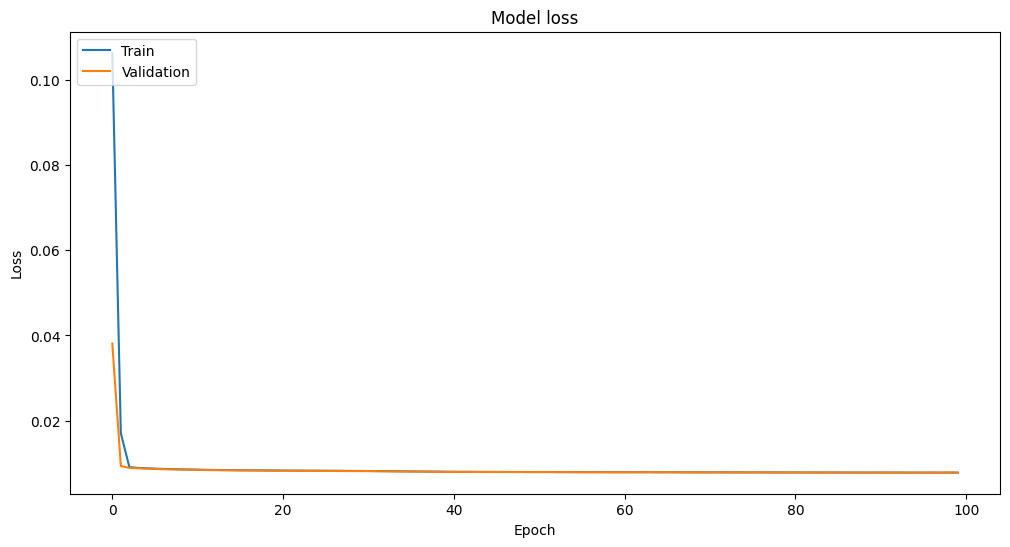

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# evaluate model
test_loss = model.evaluate(noisy_test, clean_test, verbose=0)

print(f'Test Loss: {test_loss}')

Test Loss: 0.007788161281496286


In [ ]:
# make predictions for test data
predictions = model.predict(noisy_test)

# select a random example from the test set
import numpy as np
i = np.random.choice(len(noisy_test))

# print the predicted and true values
#print('Predicted:', predictions[i])
#print('True:', clean_test[i])


200/200 [==============================] - 2s 7ms/step


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(point_cloud):
    """
    Plots a 3D point cloud using matplotlib.

    Args:
    point_cloud: np.ndarray of shape (N, 3)
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = point_cloud[:, 0]
    ys = point_cloud[:, 1]
    zs = point_cloud[:, 2]

    ax.scatter(xs, ys, zs)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


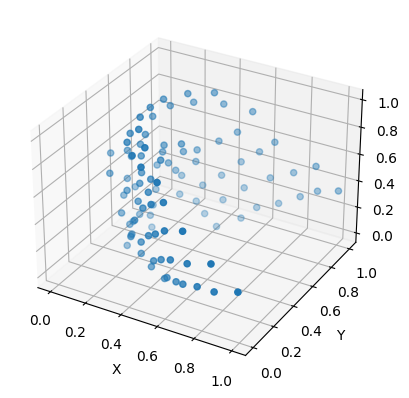

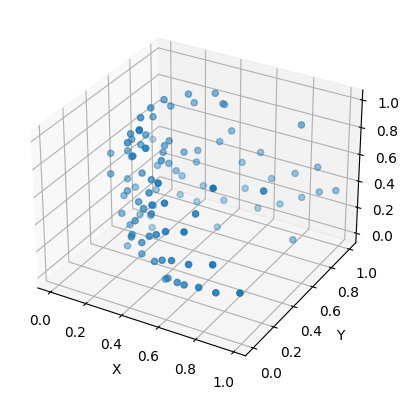

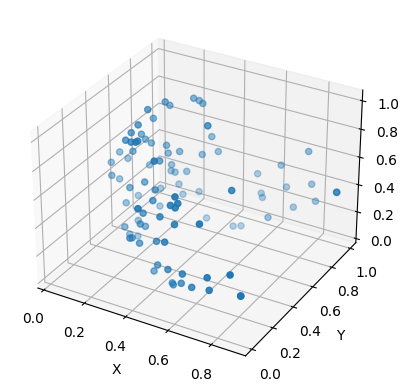

In [ ]:
%matplotlib inline

# Display a clean point cloud
plot_point_cloud(clean_test[i])

# Display its corresponding noisy point cloud
plot_point_cloud(noisy_test[i])

# Display the denoised point cloud
plot_point_cloud(predictions[i])


In [ ]:
import json
import pandas as pd

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# or save to csv:
hist_csv_file = 'gdrive/My Drive/UPJV/missing/history_gnn-4.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)